In [82]:
import imageio
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.feature_extraction import image

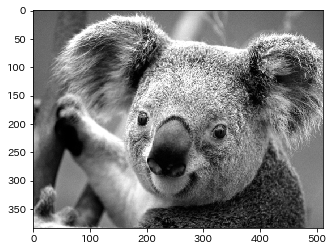

In [83]:
# read image
path = 'koala.png'
img = imageio.imread(path) 
plt.imshow(img, 'gray')

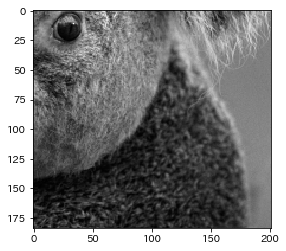

In [84]:
# crop_image
crop_h = 300
crop_w = 400
crop_size = 100
crop_img = img[crop_h - crop_size : crop_h+crop_size+1, crop_w-crop_size:crop_w+crop_size+1]
plt.imshow(crop_img, 'gray')

In [240]:
PATCH_WIDTH = 2 # patch width
PATCH_SIZE = PATCH_WIDTH * PATCH_WIDTH + 1 # patch size
ALPHA = 0.01 # hypter paramter
KNN_COUNT = 5 # neghborの数

In [241]:
# 一様分布に従うランダムな重みを作成
# この重みはpatchと同じサイズで中心ほど値が大きい正規分布に従う
# patchの重みの類似度を計算するときに中心ほど重みが大きくなるように計算する
axis = list(range(-PATCH_WIDTH, PATCH_WIDTH+1))
print(axis)
x, y = np.meshgrid(axis, axis) # axis×axisの格子状の点を作る
WEIGHT_DIST = norm.pdf(x) * norm.pdf(y) #　平均0分散1の正規分布を掛け合わせる
WEIGHT_DIST

[-2, -1, 0, 1, 2]


array([[0.00291502, 0.01306423, 0.02153928, 0.01306423, 0.00291502],
       [0.01306423, 0.05854983, 0.09653235, 0.05854983, 0.01306423],
       [0.02153928, 0.09653235, 0.15915494, 0.09653235, 0.02153928],
       [0.01306423, 0.05854983, 0.09653235, 0.05854983, 0.01306423],
       [0.00291502, 0.01306423, 0.02153928, 0.01306423, 0.00291502]])

In [291]:
# padding image
# おそらくpatchを探すときに探索範囲がpatch sizeで割り切れるための処理
pad_img = np.pad(crop_img, [PATCH_WIDTH, PATCH_WIDTH], 'symmetric')

print("crop image size: ", crop_img.shape)
print("padging image size: ", pad_img.shape)

HEIGHT, WIDTH = pad_img.shape
IMG_SIZE = HEIGHT*WIDTH
print("height: {}, width: {}".format(HEIGHT, WIDTH))

crop image size:  (184, 201)
padging image size:  (188, 205)
height: 188, width: 205


In [254]:
# patchを"全て"作成

PATCHES = image.extract_patches_2d(pad_img.T, (PATCH_SIZE, PATCH_SIZE))
# TODO
PATCHES = np.asarray([patch.T for patch in PATCHES]) # なんでてんち？
PATCH_COUNT = len(PATCHES)

print("patch shape: ", PATCHES.shape)
print("padding imageの大きさが{}x{}={}だから{}このpatchができる".format(HEIGHT,WIDTH,HEIGHT*WIDTH,PATCH_COUNT))



patch shape:  (36984, 5, 5)
padding imageの大きさが188x205=38540だから36984このpatchができる


In [244]:
# initilize offse　
# かく場所iに対して，-i〜SIZE-iのオフセットをKNN_COUNT分だけ作成
rand = (PATCH_COUNT-1) * np.random.rand(PATCH_COUNT, KNN_COUNT) # 画像サイズ*KNN_countの大きさの0-(PATCH_COUNT-1)の乱数の値をもつ行列を作成
tile = np.tile(np.arange(0, PATCH_COUNT), (KNN_COUNT, 1)).T # [[0,0,0,0,0],[1,1,1,1,1]...[38539, 38539, 38539, 38539, 38539]]
offsets = (rand - tile).astype(dtype=np.int)
offsets

array([[ 34068,  23204,  36480,  10935,  34492],
       [  2536,  26449,  28215,  36499,  22844],
       [  8685,  29889,  28310,  17923,  34510],
       ...,
       [  -235, -20754, -22608, -14458, -12975],
       [-21578, -20001, -31742, -34710,  -4467],
       [-18811, -10112, -28338, -24508, -15325]])

In [251]:
# initialize_weights
# 最初はランダムに選んだパッチで類似度を計算

# patchの類似度を計算
def patches_dissimilarity(patch1, patch2):
    diff = (patch1 - patch2) ** 2
    weighted_patch2 = diff * WEIGHT_DIST # diffを真ん中ほど大きい正規分布で重みずけ
    error = -ALPHA * diff.sum()
    return error

weights = np.ones([PATCH_COUNT, KNN_COUNT])
for i in range(PATCH_COUNT):
    patch = PATCHES[i]
    for j in range(KNN_COUNT):
        offset = offsets[i, j] # get random offset
        offset_patch = PATCHES[i + offset, :, :]
        weights[i, j] = patches_dissimilarity(patch, offset_patch)

weights

array([[-28.31, -24.56, -22.72, -24.55, -27.12],
       [-24.92, -27.33, -26.9 , -16.54, -26.61],
       [-21.21, -31.  , -34.71, -20.35, -20.86],
       ...,
       [-32.47, -27.94, -22.41, -31.1 , -32.86],
       [-30.8 , -26.98, -27.93, -30.78, -26.79],
       [-25.07, -28.98, -29.33, -38.53, -34.81]])

In [282]:
# inilize heap
## pythonのヒープ構造を扱う
## おそらく最大・最小値をすぐ取り出しするために用いられる

import heapq

# heapには重みとoffsetが記載してある．つまりあるpatchに対して，そのindex(offset)との類似度が示してある
ALL_HEAP = []
for i in range(PATCH_COUNT):
    h = []
    for j in range(KNN_COUNT):
        heapq.heappush(h, (weights[i, j], offsets[i, j]))
    
    ALL_HEAP.append(h)
        
ALL_HEAP

[[(-28.310000000000002, 34068),
  (-27.12, 34492),
  (-22.72, 36480),
  (-24.55, 10935),
  (-24.560000000000002, 23204)],
 [(-27.330000000000002, 26449),
  (-26.61, 22844),
  (-26.900000000000002, 28215),
  (-16.54, 36499),
  (-24.92, 2536)],
 [(-34.71, 28310),
  (-21.21, 8685),
  (-31.0, 29889),
  (-20.35, 17923),
  (-20.86, 34510)],
 [(-35.660000000000004, 22723),
  (-29.32, 2189),
  (-26.86, 27462),
  (-22.400000000000002, 10137),
  (-28.52, 14634)],
 [(-30.59, 9444),
  (-29.75, 1764),
  (-28.38, 12177),
  (-26.240000000000002, 15382),
  (-29.27, 15469)],
 [(-32.84, 19809),
  (-30.35, 27532),
  (-21.12, 10042),
  (-23.31, 35634),
  (-24.34, 31211)],
 [(-27.92, 32440),
  (-23.57, 36196),
  (-23.31, 35831),
  (-18.86, 9845),
  (-20.22, 18580)],
 [(-33.67, 7334),
  (-25.330000000000002, 32553),
  (-26.16, 35927),
  (-23.78, 2579),
  (-25.11, 19857)],
 [(-33.53, 30340),
  (-30.94, 2102),
  (-25.91, 24150),
  (-28.82, 28933),
  (-29.27, 22380)],
 [(-33.04, 28669),
  (-28.64, 30224),
  (-

In [289]:
# heapを新しくする

# 1-Dのindexをpositionにする
def idx2pos(idx):
    height = idx//HEIGHT
    width = idx//WIDTH
    return height, width
    
# 2-Dのpostionを1-Dのidxにする
def pix2idx(height, width):
    return HEIGHT*height+width


def update_heap(idx, other_idx):
    patch = PATCHES[idx, :, :]
    heap = ALL_HEAP[idx]
    other_heap = ALL_HEAP[other_idx]
    
    for k in range(KNN_COUNT):
        other_offset = other_heap[k][1] 

        new_idx = idx + other_offset # idx_1に違うoffsetをたす
        new_idx = np.maximum(new_idx, 0) # new_idxが溢れないように調整
        new_idx = np.minimum(new_idx, PATCH_COUNT-1) # new_idxが溢れないように調整
        new_offset = new_idx - idx # new_idxが溢れていた時のために再計算

        new_patch = PATCHES[new_idx, :, :] # 新しいpatch
        new_weight = patches_dissimilarity(patch, new_patch) # new weight

        max_weight = heap[0][0] # heap構造は頂点が最大値となる
        if max_weight < new_weight:
            heapq.heapreplace(heap, (new_weight, new_offset))
            
    return heap

pix_shift = -1 # shift量？

for w in range(0, WIDTH):
    for h in range(0, HEIGHT):
        idx = pix2idx(h, w)
        height_shift_idx = pix2idx(h+pix_shift, w) # hegihtを少しshfit
        width_shift_idx = pix2idx(h, w+pix_shift) # widthを少しshfit
        
        ALL_HEAP[idx] = update_heap(idx, height_shift_idx) # もしheapがよくなれば新しくなって帰ってくる
        ALL_HEAP[idx] = update_heap(idx, width_shift_idx) # もしheapがよくなれば新しくなって帰ってくる

In [ ]:
# random_search
n = PATCH_COUNT # ? IMG_COUNT
new_heaps = []
for idx in range(PATCH_COUNT):
    heap = ALL_HEAP[idx]
    new_heap = search_around(idx, heap)
    new_heaps.append(new_heap)
    


In [298]:
# search_around
L = 30 # hypter paramter
l = 0.5 # hypter parameter
q_range = np.arange(0, 3) # hypter paramter
cand_offsets = np.empty(())

In [299]:
q_range

array([0, 1, 2])